###Import libraries

In [190]:
try:
  import yfinance as yf
except:
  # install a library
  !pip install yfinance --upgrade --no-cache-dir 
  import yfinance as yf

In [191]:
try:
  import yahoo_fin
  from yahoo_fin import stock_info as si
except:
  # install a library
  !pip install yahoo_fin 
  import yahoo_fin
  from yahoo_fin import stock_info as si

In [192]:
# Base Libraries
import pandas as pd
import numpy as np

# Graphs
%matplotlib inline
import matplotlib.pyplot as plt
width, height = 15, 6 
plt.rcParams['figure.figsize'] = [width, height]
plt.style.use('fivethirtyeight')

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score

# SVM
from sklearn.svm import SVR, SVC, NuSVC

# Metrics
## Classification metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

##2. Data Collection

###US Stock Exchanges' list of tickers

In [193]:
# table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# SP_companies = table[0]

# SP_tickers = SP_companies['Symbol']

# SP_companies.head()

#df_companies.to_csv('S&P500-Info.csv')
#df_companies.to_csv("S&P500-Symbols.csv", columns=['Symbol'])

In [194]:
def getUsefulSymbolsSet(symbols):
  # Some stocks are 5 characters. Those stocks with the suffixes listed below are not of interest.
  suffix_notToUse = ['W', 'R', 'P', 'Q']
  del_set = set()
  sav_set = set()

  for symbol in symbols:
      if len( symbol ) > 4 and symbol[-1] in suffix_notToUse:
          del_set.add( symbol )
      else:
          sav_set.add( symbol )

  print( f'Removed {len( del_set )} unqualified stock symbols...' )
  print( f'There are {len( sav_set )} qualified stock symbols...' )

  return sav_set, del_set

In [195]:
# gather stock symbols from major US exchanges
df_SP = pd.DataFrame( si.tickers_sp500() )
df_NDQ = pd.DataFrame( si.tickers_nasdaq() )
df_DOW = pd.DataFrame( si.tickers_dow() )
df_Others = pd.DataFrame( si.tickers_other() )

# convert DataFrame to list, then to sets
sym_SP = set( symbol for symbol in df_SP[0].values.tolist() )
sym_NDQ = set( symbol for symbol in df_NDQ[0].values.tolist() )
sym_DOW = set( symbol for symbol in df_DOW[0].values.tolist() )
sym_Others = set( symbol for symbol in df_Others[0].values.tolist() )

# join the 4 sets into one. Because it's a set, there will be no duplicate symbols
symbols = set.union( sym_SP, sym_NDQ, sym_DOW, sym_Others )

sav_Symbols, del_Symbols = getUsefulSymbolsSet( symbols )

Removed 1104 unqualified stock symbols...
There are 11018 qualified stock symbols...


###Read data

In [196]:
def getHistoricalTickerData(ticker, start, end):
  # Fetch the data by specifying the number of period
  df = yf.download( ticker, #'VOO', 
                    start= start, #'2016-01-01',
                    progress=False,
                    end= end #'2022-10-28' 
                   )

  print('Shape of raw df: ', df.shape)

  # Display the first five rows of the dataframe to check the results. 
  print('First 5 rows in df: ')
  df.head()

  return df

In [197]:
df = pd.read_csv('JPM.csv', parse_dates = True, index_col = 0)

# df['Date'] = pd.to_datetime(df['Date'], yearfirst=True)

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-01-03,39.830002,40.360001,39.299999,40.189999,25.692480,12838600
2006-01-04,39.779999,40.139999,39.419998,39.619999,25.544176,13491500
2006-01-05,39.610001,39.810001,39.500000,39.740002,25.621536,8109400
2006-01-06,39.919998,40.240002,39.549999,40.020000,25.802069,7966900
2006-01-09,39.880001,40.720001,39.880001,40.669998,26.221136,16575200


In [198]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [199]:
# jpm = getHistoricalTickerData('JPM', '2006-01-01', '2022-11-01')

###Market Capitalization

In [200]:
# def marketCap(ticker):


In [201]:
# top_5 = df.sort_values(by='Forward Returns', ascending=False).head()
# print('Highest returns: \n')
# top_5

In [202]:
# top_5.plot(y='Forward Returns', kind='bar', rot=5)

##3. Exploratory Data Analysis

###Summary Statistics

In [203]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4241.000000,4241.000000,4241.000000,4241.000000,4241.000000,4.241000e+03
mean,71.944336,72.710259,71.167828,71.943244,60.993454,2.435979e+07
std,36.946053,37.217824,36.679067,36.934392,38.581940,2.062324e+07
min,15.370000,17.290001,14.960000,15.900000,11.343098,2.926400e+06
25%,42.880001,43.400002,42.299999,42.830002,30.139021,1.219680e+07
50%,57.230000,57.709999,56.750000,57.259998,45.327152,1.703780e+07
75%,102.070000,103.230003,100.769997,102.059998,92.526054,2.938780e+07
max,172.710007,172.960007,170.539993,171.779999,166.523987,2.172942e+08


###Linear Correlation

In [204]:
import seaborn as sns
%matplotlib inline

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]), dict(selector="td", props=[('padding', "0em 0em")]), dict(selector="th:hover", props=[("font-size", "12pt")]), dict(selector="tr:hover td:hover", props=[('max-width', '200px'), ('font-size', '12pt')])  ]

corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_caption("Hover to magify").set_precision(2).set_table_styles(magnify())

,Open,High,Low,Close,Adj Close,Volume
Open,1.00,1.00,1.00,1.00,1.00,-0.46
High,1.00,1.00,1.00,1.00,1.00,-0.45
Low,1.00,1.00,1.00,1.00,1.00,-0.46
Close,1.00,1.00,1.00,1.00,1.00,-0.46
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.43
Volume,-0.46,-0.45,-0.46,-0.46,-0.43,1.00


###Time Series Visualization

In [205]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa60e149d0>,
      dtype=object)

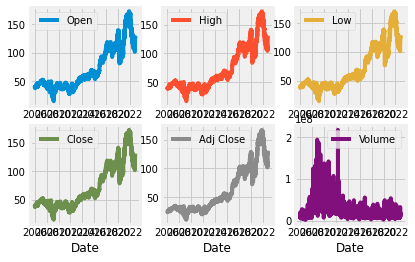

In [206]:
fig, axes = plt.subplots(nrows=2, ncols=3)
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].plot(subplots=True, ax=axes)

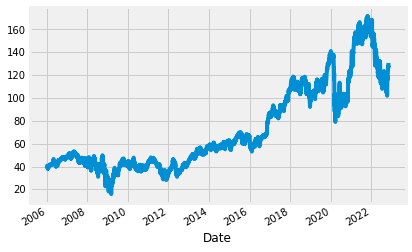

In [207]:
df['Close'].plot()

###Seasonality


In [208]:
import statsmodels.api as sm

def plotSeasonality(freq):
  if freq == None:
    freq = 'd'
  analysis = df['Close'].asfreq(freq).fillna(method='bfill').fillna(method='ffill')
  decompose_result = sm.tsa.seasonal_decompose(analysis, model='additive')
  fig = decompose_result.plot()

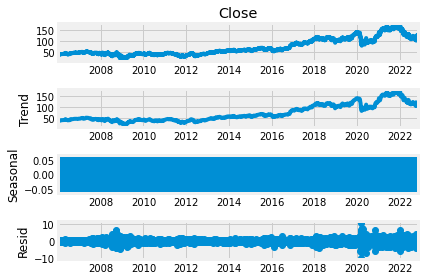

In [209]:
plotSeasonality('d')

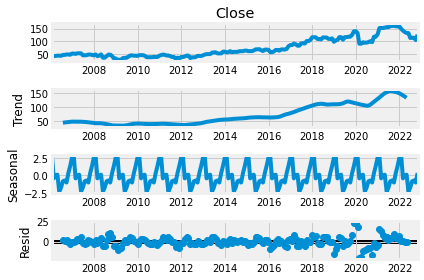

In [210]:
plotSeasonality('m')

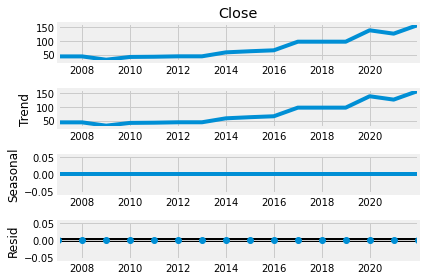

In [211]:
plotSeasonality('y')

##4. Data Cleaning

###Data Types

All time series in the data are of type float, and no categorical data that may need to be encoded is present.

In [212]:
# data types

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4241 entries, 2006-01-03 to 2022-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4241 non-null   float64
 1   High       4241 non-null   float64
 2   Low        4241 non-null   float64
 3   Close      4241 non-null   float64
 4   Adj Close  4241 non-null   float64
 5   Volume     4241 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 361.0 KB


###Missing Data

We see that the data does not have any missing values which need to be handled, at this point in our analysis.

In [213]:
# missing data

df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

###Outliers

In [214]:
top_5 = df.sort_values(by='Close', ascending=False).head()
print('Highest returns: \n')
top_5

Highest returns: 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-22,170.029999,172.089996,169.699997,171.779999,166.523987,8817900
2021-10-26,171.000000,172.490005,170.539993,171.399994,166.155594,8015100
2021-10-25,172.710007,172.960007,170.479996,170.940002,165.709671,10159200
2021-10-20,168.300003,170.869995,167.460007,170.839996,165.612732,8185600
2021-11-03,170.130005,171.130005,169.149994,170.529999,165.312241,8402700


In [215]:
bottom_5 = df.sort_values(by='Close', ascending=True).head()
print('Lowest returns: \n')
top_5

Lowest returns: 



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-22,170.029999,172.089996,169.699997,171.779999,166.523987,8817900
2021-10-26,171.000000,172.490005,170.539993,171.399994,166.155594,8015100
2021-10-25,172.710007,172.960007,170.479996,170.940002,165.709671,10159200
2021-10-20,168.300003,170.869995,167.460007,170.839996,165.612732,8185600
2021-11-03,170.130005,171.130005,169.149994,170.529999,165.312241,8402700


In [216]:
# df with these outliers in March 2020 dropped
# df_clean = df[ ~df[ (df.index.year == 2020) & (df.index.month == 3) ] ]

##5. Transformation

###Feature Engineering

We first create a few typically used features for algorithmic asset returns trend prediction.

In [217]:
target_feature = 'Close'

In [218]:
df['O-C'] = df['Open'] - df['Close']
df['H-L'] = df['High'] - df['Low'] # does the trend depend on vol? not really

# Lagged returns may matter, since best predictor of a univariate time series is its own past behaviour. Note that no seasonal behaviour is observed
def laggedTimeSeries( lag = 6, target_feature = target_feature ):
  for i in range(1,lag+1):
    df[str('Lagged '+str(i))] =  df[target_feature].shift(-i)  
laggedTimeSeries( lag = 6, target_feature = target_feature )

# Momentum may matter, though no seasonal behaviour is observed. Indicate whether long MA is above short MA
df['Momentum 6'] =  df[target_feature].diff().shift(-6)  
df['Momentum 30'] =  df[target_feature].diff().shift(-30)  

# Moving Averages
df['SMA'] = df[target_feature].rolling(30).mean()  # Should ideally pick one out of SMA and EMA

alpha = 2/( df[target_feature].count() + 1)
df['EMA'] = df[target_feature].ewm(alpha=alpha).mean()# Kind of a wted avg, more wt to near past, less wt to far past

In [219]:
# Seasonality indicators
df3 = pd.get_dummies(df.index.month) 
df3.columns = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df3['Date'] = df.index
df3.set_index('Date', inplace=True)

df2 = pd.concat( [ df, df3 ], axis=1)
df = df2

In [228]:
df['Sign'] = np.sign(np.log(df[target_feature]).diff().shift(-1).shift(-1))

In [224]:
df.shape

(4241, 31)

In [225]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Sign,Lagged 1,...,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-03,39.830002,40.360001,39.299999,40.189999,25.692480,12838600,-0.359997,1.060002,1.0,39.619999,...,0,0,0,0,0,0,0,0,0,0
2006-01-04,39.779999,40.139999,39.419998,39.619999,25.544176,13491500,0.160000,0.720001,1.0,39.740002,...,0,0,0,0,0,0,0,0,0,0
2006-01-05,39.610001,39.810001,39.500000,39.740002,25.621536,8109400,-0.130001,0.310001,1.0,40.020000,...,0,0,0,0,0,0,0,0,0,0
2006-01-06,39.919998,40.240002,39.549999,40.020000,25.802069,7966900,-0.100002,0.690003,1.0,40.669998,...,0,0,0,0,0,0,0,0,0,0
2006-01-09,39.880001,40.720001,39.880001,40.669998,26.221136,16575200,-0.789997,0.840000,-1.0,40.730000,...,0,0,0,0,0,0,0,0,0,0


In [226]:
# Removing any null values
df.dropna(inplace=True)

Next, we check the linear correlation between all the features and the target variable.

In [227]:
# check linear corr between the features  >>> pick the less dependent ones + with y >>> pick the more dependent one

# calculate the correlation matrix
corr = df.corr()

# plot the heatmap
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]), dict(selector="td", props=[('padding', "0em 0em")]), dict(selector="th:hover", props=[("font-size", "12pt")]), dict(selector="tr:hover td:hover", props=[('max-width', '200px'), ('font-size', '12pt')])  ]

corr.style.background_gradient(cmap, axis=1).set_properties(**{'max-width': '80px', 'font-size': '10pt'}).set_caption("Hover to magify").set_precision(2).set_table_styles(magnify())

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Sign,Lagged 1,Lagged 2,Lagged 3,Lagged 4,Lagged 5,Lagged 6,Momentum 6,Momentum 30,SMA,EMA,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
Open,1.00,1.00,1.00,1.00,1.00,-0.46,0.03,0.45,-0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01
High,1.00,1.00,1.00,1.00,1.00,-0.46,0.01,0.47,-0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.93,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01
Low,1.00,1.00,1.00,1.00,1.00,-0.47,0.01,0.44,-0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.01,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01
Close,1.00,1.00,1.00,1.00,1.00,-0.46,-0.00,0.45,-0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01
Adj Close,1.00,1.00,1.00,1.00,1.00,-0.43,0.00,0.47,-0.01,1.00,1.00,1.00,0.99,0.99,0.99,-0.02,-0.01,0.99,0.94,0.02,0.01,-0.01,-0.00,-0.00,-0.01,-0.01,0.00,-0.00,-0.01,0.00,0.01
Volume,-0.46,-0.46,-0.47,-0.46,-0.43,1.00,0.01,0.23,0.00,-0.46,-0.46,-0.46,-0.46,-0.46,-0.46,-0.01,-0.00,-0.45,-0.34,0.05,0.01,0.07,0.02,0.00,0.01,-0.01,-0.07,-0.03,0.00,-0.02,-0.04
O-C,0.03,0.01,0.01,-0.00,0.00,0.01,1.00,0.02,-0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,-0.03,0.02,0.02,-0.01,-0.02,0.00,-0.00,0.00,0.04,-0.02,0.00,0.00,-0.00,-0.00,0.01
H-L,0.45,0.47,0.44,0.45,0.47,0.23,0.02,1.00,-0.01,0.45,0.45,0.45,0.45,0.45,0.45,-0.02,-0.02,0.49,0.57,0.03,0.00,0.09,0.01,-0.01,-0.01,-0.03,-0.04,-0.00,0.01,-0.02,-0.02
Sign,-0.01,-0.01,-0.01,-0.01,-0.01,0.00,-0.01,-0.01,1.00,-0.01,0.01,0.01,0.01,0.01,0.01,-0.04,-0.02,-0.01,-0.02,0.02,0.01,0.00,0.01,-0.04,-0.02,0.01,-0.00,0.01,-0.00,-0.01,0.01
Lagged 1,1.00,1.00,1.00,1.00,1.00,-0.46,0.00,0.45,-0.01,1.00,1.00,1.00,1.00,1.00,1.00,-0.02,-0.01,0.99,0.92,0.02,0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.00,-0.00,-0.01,0.00,0.01


###Feature Scaling

We include the minmax scaler in the Pipeline function in the Modeling step.

###Feature and Target sets

In [229]:
# take out the Predictor variable
X = df.drop( ['Close'], axis=1).values

X.shape # Predictors should be of 2D

(4182, 30)

In [230]:
# take out the Target variable
y = df['Close'].values

y.shape  # Target Label should be 1D

(4182,)

##6. Modelling

###Split Data

In [233]:
# Splitting the datasets into training and testing data.
# Keep shuffle = False for financial time series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 3763, 419


###Default Model Fit, Predict and Performance

Fit Model

Here, we fit an "hyper-parameter non-tuned" model, using the default parameters values for NuSVC, with the minmaxscaler for scaling the training and testing datasets.

In [ ]:
# Scale and fit the model
pipe = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("Regressor", NuSVC())
]) 
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', NuSVC())])

In [ ]:
# Target classes
class_names = pipe.classes_
class_names

array([0, 1])

Predict Model

In [ ]:
# Predicting the test dataset
y_pred = pipe.predict(X_test)

In [ ]:
# predict
y_pred[:10]

array([1, 0, 0, 0, 1, 0, 0, 0, 0, 0])

Performance Metrics

###Hyper-Parameter Tuning

In [ ]:
# First 3 split
tscv = TimeSeriesSplit(n_splits=3, gap=1)
for train, test in tscv.split(X):
    print(train, test)

In [ ]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [ ]:
# Get parameters list
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('classifier', NuSVC())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'classifier': NuSVC(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'classifier__break_ties': False,
 'classifier__cache_size': 200,
 'classifier__class_weight': None,
 'classifier__coef0': 0.0,
 'classifier__decision_function_shape': 'ovr',
 'classifier__degree': 3,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'rbf',
 'classifier__max_iter': -1,
 'classifier__nu': 0.5,
 'classifier__probability': False,
 'classifier__random_state': None,
 'classifier__shrinking': True,
 'classifier__tol': 0.001,
 'classifier__verbose': False}

In [ ]:
# Perform Gridsearch and fit
param_grid = {
    # 'classifier__break_ties': False,
    # 'classifier__cache_size': 200,
    # 'classifier__class_weight': None,
    # 'classifier__coef0': 0.0,
    # 'classifier__decision_function_shape': 'ovr',
    # 'classifier__degree': [3, 6],
    'classifier__gamma': ['scale', 'auto'],
    # 'classifier__max_iter': -1,
    'classifier__nu': [0.1, 0.5],
    # 'classifier__probability': False,
    'classifier__random_state': [1],
    # 'classifier__shrinking': True,
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'classifier__tol': [0.01, 0.001, 0.0001]
            }

In [ ]:
grid_search = GridSearchCV(pipe, param_grid, scoring='roc_auc', n_jobs=-1, cv=tscv, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('classifier', NuSVC())]),
             n_jobs=-1,
             param_grid={'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'poly', 'rbf',
                                                'sigmoid'],
                         'classifier__nu': [0.1, 0.5],
                         'classifier__random_state': [1],
                         'classifier__tol': [0.01, 0.001, 0.0001]},
             scoring='roc_auc', verbose=1)

Best Parameters

In [ ]:
# Best Params
grid_search.best_params_

{'classifier__gamma': 'auto',
 'classifier__kernel': 'rbf',
 'classifier__nu': 0.5,
 'classifier__random_state': 1,
 'classifier__tol': 0.01}

In [ ]:
# Best Score
grid_search.best_score_

0.5599396313431095

Final Model

In [ ]:
# Instantiate SVC model with search param
clf = NuSVC(  
    gamma='auto',
    kernel= 'sigmoid',
    nu= 0.5,
    random_state= 1,
    tol= 0.001 )

In [ ]:
# Scale and fit the model
clf = Pipeline([
    ("scaler", MinMaxScaler()), 
    ("classifier", clf)
]) 
clf.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier',
                 NuSVC(gamma='auto', kernel='sigmoid', random_state=1))])

In [ ]:
# Predicting the test dataset
y_pred = clf.predict(X_test)

##7. Metrics

###Model Performance Metrics

###Trading Strategy

In [ ]:
# Subsume into a new dataframe
df1 = df.copy()                      # df[-len(X_test)
df1['Signal'] = clf.predict(X)       # clf.predict(X_test)

In [ ]:
# Strategy Returns
df1['Strategy'] = df1['Forward Returns'] * df1['Signal'].fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

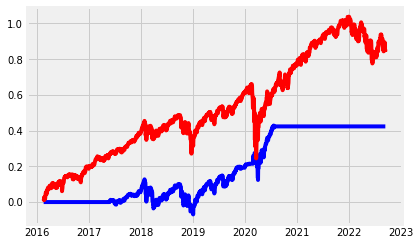

In [ ]:
# plot 
plt.plot(np.cumsum(df1['Strategy']), color = 'blue')
plt.plot(np.cumsum(df['Forward Returns']), color = 'red')

#**Results**

#**References**

https://scikit-learn.org/stable/modules/svm.html#shrinking-svm
https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC
https://en.wikipedia.org/wiki/Algorithmic_trading
https://www.investopedia.com/articles/active-trading/011815/top-technical-indicators-rookie-traders.asp
https://www.investopedia.com/articles/07/mean_reversion_martingale.asp
